# ChatBot

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input , Embedding , LSTM , Dense , GlobalMaxPooling1D , Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [12]:
%%writefile content.json
{"intents":
 [
     {
         "tag":"greatings",
         "input":["hello","hi there","nice to meet you","hi","hey there","hey"],
         "responses":[
             "Hi. welcome",
             "Hey yo, do you need help i ?",
             "Welcome aboard , how may i help you ?",
             "ahoy!!",
             "Hi random person , what do you want ?",
             "Hello my person , how can i help you ?",
             "Ha , Glad you showed up . How are you ?"
         ]
     } , 
     
     {
         "tag":"goodbye",
         "input":["Thank You" , "Thanks" , "Thanks for the info" , "bye" , "adios" , "ok.bye" , "goodbye" , "see you later" , "i will catch you later" ],
         "responses":[
             "okay, bye",
             "Have a nice day",
             "Adios",
             "Goodbye",
             "See you later",
             "nice conversation",
             "bye",
             "okay , have a nice day",
             "Take care",
             "We will meet soon",
             "Yeah sure . will talk to you later",
             "Okay , Take Care"
         ]
     } ,
     {
         "tag":"howami",
         "input":["how are you ?" , "i am fine" , "are you fine ?" , "how are things going on ?" , "everything going on okay ?" , "how is every thing is going"],
         "responses":[
             "Yeah , am fine",
             "Every thing is going on well",
             "Doing good . Thanks you are my best friend",
             "Things are great",
             "Yeah Fine , nothing much going in my life",
             "Everythings great",
             "I am doing good . Life is boring . Need to go on an adventure"
         ]
     } ,
     {
         "tag":"whoareyou",
         "input":["who are you ?" , "what are you ?" , "what is your name ?" , "are you a chatbot ?" , "what can i call you ?" , "your name ?" , "are you a bot ? "],
         "responses":[
             "I am a chatbot . You can call me Bchat",
             "I am a Bchat you could ask questions",
             "Bchat as your service",
             "My name is Bchat and yes i am a chat bot",
             "I am here to help you"
         ]
     } ,
     {
         "tag":"whereareyou",
         "input":["Where are you from ?" , "Which country are you from ?" , "Where do you live ?" , "Where are you ?" , "Where do you live in ?" , "which place do you live in"],
         "responses":[
             "I live in southern province",
             "I live in southern province . Pretty sure you would not have heared about that",
             "Souther province . thats where i live in"
         ]
     } ,
     
     {
         "tag":"join",
         "input":["How to get recruit ?" , "How to join ?" , "How do i get recruit ?" , "How do i join ?"],
         "responses":[
             "you need contact the nearest HR office once you have the complete the pre requisites",
             "contact the closet HR office from your location",
             "well. there are some pre-requisites and after you complete them , find the HR office"
             ]
     } ,
     
     {
         "tag":"whereisthehroffice",
         "input":["Where is the HR office located ?" , "location of the HR office ?" , "HR office's location ?" , "Where can i find the HR office ?"],
         "responses":[
             "That's up to you . use your skills",
             "They are present all over the city you live in . find them on your own . I can not give any more information",
             "There are a lot of HR offices in the city you are in . find them"
         ]
     } 
     
 ]
}

Overwriting content.json


### importing data

In [13]:
with open('content.json') as content:
    data1 = json.load(content)

### get all the data to list

In [17]:
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
    responses[intent['tag']]=intent['responses']
    for lines in intent['input']:
        inputs.append(lines)
        tags.append(intent['tag'])
    

### converting to data frames

In [18]:
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

### printing the data

data

In [20]:
data = data.sample(frac=1)

## Pre-Processing

### removing punctuations

In [21]:
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
11,okbye,goodbye
10,adios,goodbye
12,goodbye,goodbye
7,thanks,goodbye
0,hello,greatings
19,everything going on okay,howami
9,bye,goodbye
26,your name,whoareyou
28,where are you from,whereareyou
18,how are things going on,howami


### tokenize the data

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])

#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [29]:
input_shape = x_train.shape[1]
print(input_shape)

7


### define vocabulary

In [30]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length : ",output_length)

number of unique words :  61
output length :  7


# Neural Network

### creating the model

In [31]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model = Model(i,x)

### compiling the model

In [32]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

### train the model

In [35]:
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
2/2 [==============================] - 0s 6ms/step - loss: 0.2119 - accuracy: 0.9762
Epoch 2/200
2/2 [==============================] - 0s 5ms/step - loss: 0.2093 - accuracy: 0.9762
Epoch 3/200
2/2 [==============================] - 0s 6ms/step - loss: 0.2068 - accuracy: 0.9762
Epoch 4/200
2/2 [==============================] - 0s 5ms/step - loss: 0.2037 - accuracy: 0.9762
Epoch 5/200
2/2 [==============================] - 0s 6ms/step - loss: 0.2006 - accuracy: 0.9762
Epoch 6/200
2/2 [==============================] - 0s 5ms/step - loss: 0.1972 - accuracy: 0.9762
Epoch 7/200
2/2 [==============================] - 0s 6ms/step - loss: 0.1956 - accuracy: 0.9762
Epoch 8/200
2/2 [==============================] - 0s 7ms/step - loss: 0.1935 - accuracy: 0.9762
Epoch 9/200
2/2 [==============================] - 0s 5ms/step - loss: 0.1908 - accuracy: 0.9762
Epoch 10/200
2/2 [==============================] - 0s 5ms/step - loss: 0.1880 - accuracy: 0.9762
Epoch 11/200
2/2 [===========

2/2 [==============================] - 0s 5ms/step - loss: 0.0840 - accuracy: 1.0000
Epoch 85/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0835 - accuracy: 1.0000
Epoch 86/200
2/2 [==============================] - 0s 6ms/step - loss: 0.0822 - accuracy: 1.0000
Epoch 87/200
2/2 [==============================] - 0s 4ms/step - loss: 0.0816 - accuracy: 1.0000
Epoch 88/200
2/2 [==============================] - 0s 4ms/step - loss: 0.0808 - accuracy: 1.0000
Epoch 89/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0800 - accuracy: 1.0000
Epoch 90/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0792 - accuracy: 1.0000
Epoch 91/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0785 - accuracy: 1.0000
Epoch 92/200
2/2 [==============================] - 0s 6ms/step - loss: 0.0777 - accuracy: 1.0000
Epoch 93/200
2/2 [==============================] - 0s 7ms/step - loss: 0.0770 - accuracy: 1.0000
Epoch 94/200
2/2 [===============

2/2 [==============================] - 0s 5ms/step - loss: 0.0402 - accuracy: 1.0000
Epoch 168/200
2/2 [==============================] - 0s 6ms/step - loss: 0.0400 - accuracy: 1.0000
Epoch 169/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0396 - accuracy: 1.0000
Epoch 170/200
2/2 [==============================] - 0s 6ms/step - loss: 0.0393 - accuracy: 1.0000
Epoch 171/200
2/2 [==============================] - 0s 6ms/step - loss: 0.0390 - accuracy: 1.0000
Epoch 172/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0387 - accuracy: 1.0000
Epoch 173/200
2/2 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 1.0000
Epoch 174/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0381 - accuracy: 1.0000
Epoch 175/200
2/2 [==============================] - 0s 4ms/step - loss: 0.0379 - accuracy: 1.0000
Epoch 176/200
2/2 [==============================] - 0s 5ms/step - loss: 0.0375 - accuracy: 1.0000
Epoch 177/200
2/2 [=====

# Model Analysis

### plotting the model accuracy

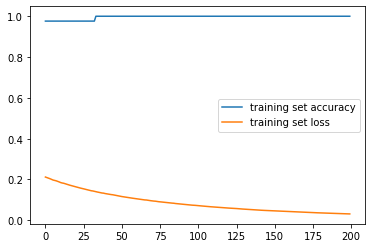

In [36]:
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()